### Overlapping Outcomes

Chapter 3에서는 observation feature $X_i$에 label $y_i$를 배분했다. 여기서 $y_i$는 기간 $[t_{i,0}, t_{i, 1}]$ 내에서 발생한 가격 바의 함수였다. $t_{i,1} > t_{j,0}$이고 $i<j$이면 $y_i$와 $y_j$는 둘 다 공통 수익률 $r_{t_{j,0},\min\{t_{i,1}, t_{j,1}\}}$에 의존한다. 즉 구간 $[t_{j,0},\min\{t_{i,1}, t_{j,1}\}]$의 수익률이다. 이는 label의 계열 $\{y_i\}-{i, \dots, I}$는 두 연속 $y_i$에 중첩이 있을 때마다 IID가 아니라는 것을 암시한다.

### Number of Concurrent Labels

두 label $y_i, y_j$가 **적어도 하나**의 공통 수익률 $r_{t-1, t} = \frac{p_t}{p_{t-1}} - 1$을 가지면 시간 $t$에서 공존한다(concurrent)라고 한다. 이 중첩은 시간 구간의 관점에서 해당 구간 너비가 서로 완벽하게 일치할 필요는 없다. 이 절에서는 주어진 수익률 $r_{t-1, t}$의 함수인 label의 개수를 계산해 본다.

1. 각 시간 $t = 1, \dots, T$에서 이진 행렬 ${1_{t,i}}_{i = 1,\dots, I}$를 구성하는데 여기서 $1_{t,i} \in \{0, 1\}$이다. 변수 $1_{t,i}$는 오직 $[t_{i,0}, t_{i,1}]$과 $[t-1, t]$가 중첩될 경우에만 그 값이 1이고, 그렇지 않다면 0이다. label의 폭 $\{[t_{i,0}, t_{i,1}]\}_{i=1,\dots,I}$는 Chapter 3에서 소개한 `t1` 객체에 정의된다는 것을 기억하자. 
2. 시간 $t, c_t = \sum_{i=1}^I 1_{t,i}$에서 concurrent label의 개수를 계산해 보자

$$c_t = \sum_{i=1}^I 1_{t,i}$$

아래의 코드는 이 로직을 구현한다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from FinancialMachineLearning.sample_weights.concurrency import *
from FinancialMachineLearning.utils.multiprocess import *
from FinancialMachineLearning.labeling.labeling import *
from FinancialMachineLearning.features.volatility import daily_volatility

start_date = '2000-01-01'
end_date = '2024-04-29'
ticker = 'AAPL'
data = yf.download(
    ticker, 
    start = start_date, 
    end = end_date
)

[*********************100%%**********************]  1 of 1 completed


In [2]:
vertical_barrier = add_vertical_barrier(
    data.index, 
    data['Close'], 
    num_days = 15 # expariation limit
)
vertical_barrier.head()

Date
2000-01-03   2000-01-18
2000-01-04   2000-01-19
2000-01-05   2000-01-20
2000-01-06   2000-01-21
2000-01-07   2000-01-24
Name: Date, dtype: datetime64[ns]

In [3]:
volatility = daily_volatility(
    data['Close'], 
    lookback = 60 # moving average span
)

In [4]:
triple_barrier_events = get_events(
    close = data['Close'],
    t_events = data.index[2:],
    pt_sl = [2, 1], # profit taking 2, stopping loss 1
    target = volatility, # dynamic threshold
    min_ret = 0.01, # minimum position return
    num_threads = 1, # number of multi-thread 
    vertical_barrier_times = vertical_barrier, # add vertical barrier
    side_prediction = None # betting side prediction (primary model)
)
triple_barrier_events.head()

,t1,trgt,pt,sl
Date,,,,
2000-01-07,2000-01-11,0.016797,2,1
2000-01-10,2000-01-12,0.026415,2,1
2000-01-11,2000-01-12,0.024043,2,1
2000-01-12,2000-01-13,0.031168,2,1
2000-01-13,2000-01-19,0.050703,2,1


In [5]:
labels = meta_labeling(
    triple_barrier_events, 
    data['Close']
)

In [6]:
labels.head()

,ret,trgt,bin
Date,,,
2000-01-07,-0.067839,0.016797,-1
2000-01-10,-0.108056,0.026415,-1
2000-01-11,-0.059973,0.024043,-1
2000-01-12,0.109677,0.031168,1
2000-01-13,0.101422,0.050703,0


In [7]:
labels['bin'].value_counts()

 0    2131
 1    2082
-1    1892
Name: bin, dtype: int64

In [8]:
num_threads = 1
num_conc_events = mp_pandas_obj(
    concurrent_events, 
    ('molecule', triple_barrier_events.index), 
    num_threads, 
    close_series_index = data['Close'].index, 
    label_endtime = triple_barrier_events['t1']
)

In [9]:
num_conc_events = num_conc_events.reindex(data['Close'].index).fillna(0)

In [10]:
num_conc_events

Date
2000-01-03    0.0
2000-01-04    0.0
2000-01-05    0.0
2000-01-06    0.0
2000-01-07    1.0
             ... 
2024-04-22    5.0
2024-04-23    6.0
2024-04-24    7.0
2024-04-25    8.0
2024-04-26    9.0
Length: 6118, dtype: float64

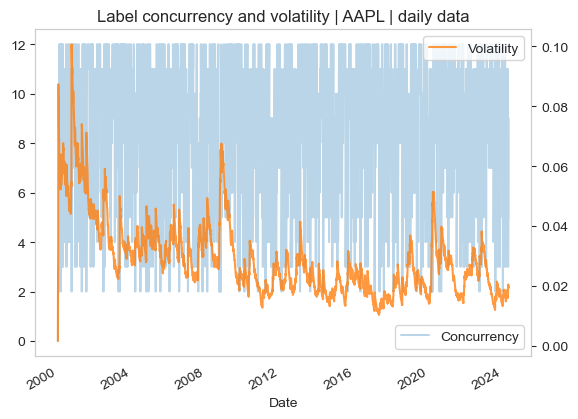

In [11]:
num_conc_events.plot(alpha = 0.3)
plt.legend(['Concurrency'])
plt.grid(False)
volatility.plot(secondary_y = True, alpha = 0.8)
plt.legend(['Volatility'])
plt.grid(False)
plt.title('Label concurrency and volatility | AAPL | daily data')
plt.show()

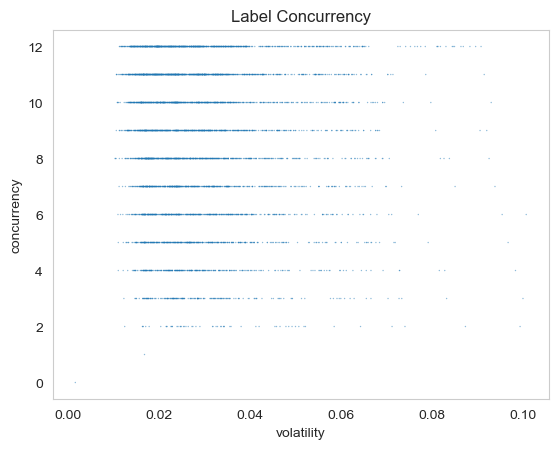

In [12]:
plt.scatter(
    volatility[1:], num_conc_events[3:], 
    marker = '.', 
    alpha = 0.5, 
    edgecolor = 'none', 
    s = 4
)
plt.grid(False)
plt.xlabel('volatility')
plt.ylabel('concurrency')
plt.title('Label Concurrency')
plt.show()

### Average Uniqueness of a Label

In [13]:
avg_unique = mp_pandas_obj(
    average_uniqueness, 
    ('molecule', triple_barrier_events.index), 
    num_threads, 
    label_endtime = triple_barrier_events['t1'], 
    num_conc_events = num_conc_events
)
avg_unique.head()

Date
2000-01-07    0.611111
2000-01-10    0.388889
2000-01-11    0.333333
2000-01-12    0.416667
2000-01-13    0.395833
dtype: float64

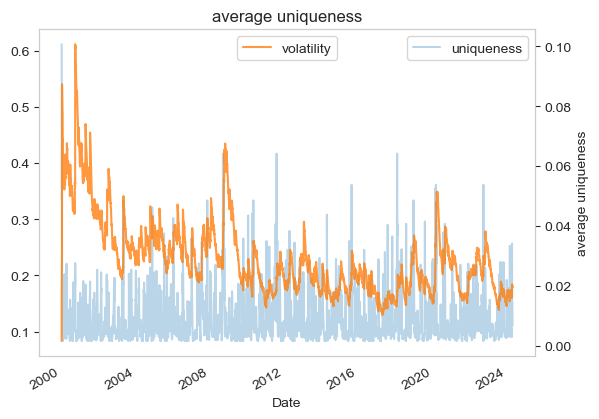

In [14]:
avg_unique.plot(alpha = 0.3)
plt.legend(['uniqueness'])
plt.grid(False)
volatility.plot(secondary_y = True, alpha = 0.8)
plt.legend(['volatility'], loc = 'upper center')
plt.grid(False)
plt.title('average uniqueness')
plt.xlabel('concurrency')
plt.ylabel('average uniqueness')
plt.show()

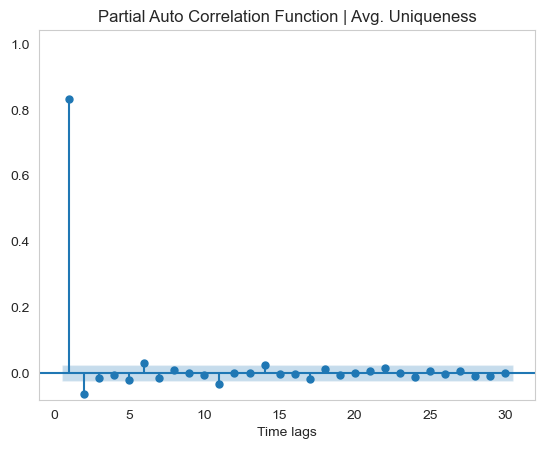

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(avg_unique, auto_ylims = True, lags = range(1, 31))
plt.grid(False)
plt.xlabel('Time lags', fontsize = 10)
plt.title('Partial Auto Correlation Function | Avg. Uniqueness')
plt.show()

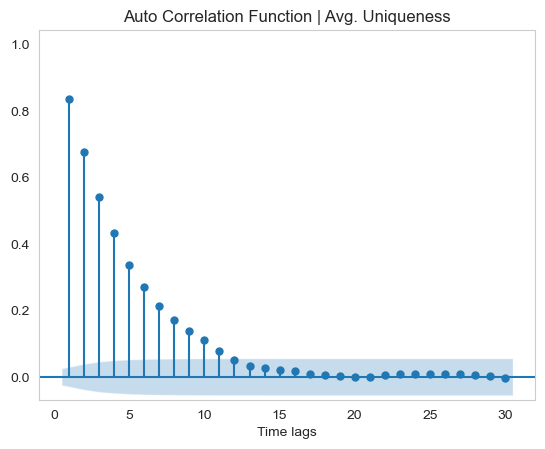

In [16]:
plot_acf(avg_unique, auto_ylims = True, lags = range(1, 31))
plt.grid(False)
plt.xlabel('Time lags', fontsize = 10)
plt.title('Auto Correlation Function | Avg. Uniqueness')
plt.show()

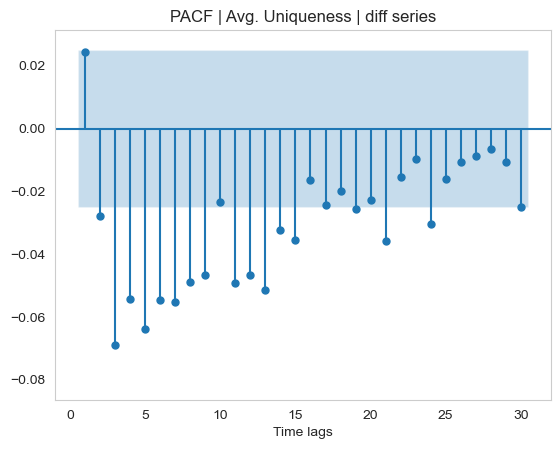

In [17]:
plot_pacf(avg_unique.pct_change().dropna(), auto_ylims = True, lags = range(1, 31))
plt.grid(False)
plt.xlabel('Time lags', fontsize = 10)
plt.title('PACF | Avg. Uniqueness | diff series')
plt.show()

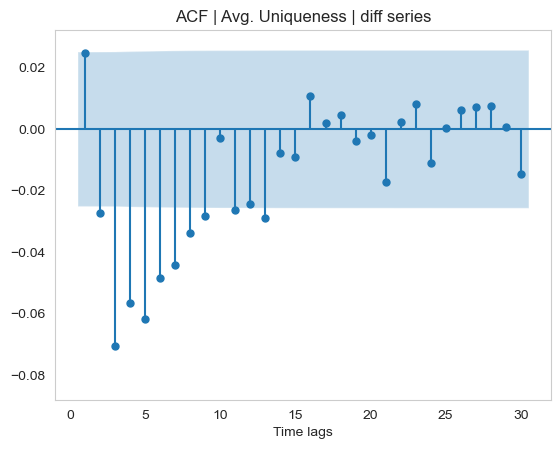

In [18]:
plot_acf(avg_unique.pct_change().dropna(), auto_ylims = True, lags = range(1, 31))
plt.grid(False)
plt.xlabel('Time lags', fontsize = 10)
plt.title('ACF | Avg. Uniqueness | diff series')
plt.show()